# Emotion Detection using Tensorflow 

## Impoting the Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, AveragePooling2D, Activation, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Loading the Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls "/content/drive/My Drive/Dataset"

fer.csv


In [4]:
file_path = "/content/drive/My Drive/Dataset/fer.csv"
df_face = pd.read_csv(file_path)

In [5]:
df_face.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [6]:
df_face.shape

(35887, 3)

In [7]:
## Splitting the dataset to get individual pixels
df_face['pixel'] = df_face.apply(lambda row: row.pixels.split(" "), axis = 1)

In [8]:
df_face.head()

,emotion,pixels,Usage,pixel
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4..."
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ..."
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ..."
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2..."
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23..."


In [9]:
## Droping Pixels column since it's not required
df_face.drop(columns = "pixels", axis = 1, inplace = True)
df_face.rename(columns = {"pixel": "pixels"}, inplace = True)
df_face.head()

,emotion,Usage,pixels
0,0,Training,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4..."
1,0,Training,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ..."
2,2,Training,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ..."
3,4,Training,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2..."
4,6,Training,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23..."


In [10]:
## Creating copy of dataframs to view image using below function
df = df_face.copy()

In [11]:
## Function to view image using pixel values
def view_image(data, row_id):
  emotion = {0 : "Angry", 1 : "Disgust", 2 : "Fear", 3 : "Happy", 4 : "Sad", 5 : "Surprise", 6 : "Neutral"}
  num_emotion = data['emotion'][row_id]
  print(num_emotion, emotion[num_emotion])
  img = np.array(np.float32(data['pixels'][row_id]).reshape(48,48,1))
  pil_img = tf.keras.preprocessing.image.array_to_img(img)
  imgplot = plt.imshow(pil_img)
  plt.show()

3 Happy


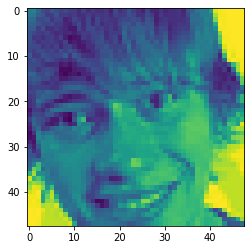

In [12]:
view_image(df,7997)

In [13]:
## Converting it into Float 32

df_face['pixels'] = df_face.apply(lambda row: np.array(np.float32(row.pixels)), axis=1)

In [14]:
## Normalising the data

df_face['pixels'] = df_face.apply(lambda row: np.array(row.pixels) / 255, axis=1)

In [15]:
df_face.head()

,emotion,Usage,pixels
0,0,Training,"[0.27450982, 0.3137255, 0.32156864, 0.28235295..."
1,0,Training,"[0.5921569, 0.5882353, 0.5764706, 0.60784316, ..."
2,2,Training,"[0.90588236, 0.83137256, 0.6117647, 0.6431373,..."
3,4,Training,"[0.09411765, 0.1254902, 0.14117648, 0.11764706..."
4,6,Training,"[0.015686275, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."


In [16]:
df_face.shape

(35887, 3)

In [17]:
## Checking count of fields for test train split
cnt = df_face.groupby("Usage").count()
print(cnt)

             emotion  pixels
Usage                       
PrivateTest     3589    3589
PublicTest      3589    3589
Training       28709   28709


In [18]:
## Checking count of fields for test train split
cnt = df_face.groupby(["Usage","emotion"]).count()
print(cnt)

                     pixels
Usage       emotion        
PrivateTest 0           491
            1            55
            2           528
            3           879
            4           594
            5           416
            6           626
PublicTest  0           467
            1            56
            2           496
            3           895
            4           653
            5           415
            6           607
Training    0          3995
            1           436
            2          4097
            3          7215
            4          4830
            5          3171
            6          4965


Dividing the data fro Train, Test and Validation as below:

Train = Training (80%)

Test = PublicTest (10%)

Validation = PrivateTest (10%)

From Training stats :
 
0 --> 3995

1 --> 436

2 --> 4097

3 --> 7215

4 --> 4830

5 --> 3171

6 --> 4965

The data set for trainging has higher samples of Happy faces and very less sample of Disgust sample. So the classes are impalanced for tranining.

In [19]:
# Training Set
X_train = np.array(df_face[df_face["Usage"] == "Training"]["pixels"].to_list())
Y_train = df_face[df_face["Usage"] == "Training"]["emotion"]

#Validation Set
X_val = np.array(df_face[df_face["Usage"] == "PrivateTest"]["pixels"].to_list())
Y_val = df_face[df_face["Usage"] == "PrivateTest"]["emotion"]

#Test Set
X_test = np.array(df_face[df_face["Usage"] == "PublicTest"]["pixels"].to_list())
Y_test = df_face[df_face["Usage"] == "PublicTest"]["emotion"]

In [20]:
## reshaping the data sets
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1) 
X_val = X_val.reshape(X_val.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

In [21]:
## Converting Target column into Categorical Dataset

Y_train = tf.keras.utils.to_categorical(Y_train, 7) 
Y_test = tf.keras.utils.to_categorical(Y_test, 7)
Y_val = tf.keras.utils.to_categorical(Y_val, 7)

type(Y_train)

numpy.ndarray

In [22]:
Y_train.shape

(28709, 7)

In [23]:
## Converitng data into dataframe for model to accept the data
Y_train = pd.DataFrame(Y_train)
Y_test = pd.DataFrame(Y_test)
Y_val = pd.DataFrame(Y_val)

In [24]:
## Checking Shape of sample:
img_width = 48
img_height = 48
import tensorflow.keras.backend as k
if k.image_data_format()=='channels_first': 
    input_shape=(1, img_width, img_height)
else:
    input_shape=(img_width,img_height,1)

## Creating the Model

In [25]:
## Function to get Model Stats

def model_stats(training_model):
  print(training_model.history.keys())
  # summarize training for accuracy
  plt.plot(training_model.history['accuracy'])
  plt.plot(training_model.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize traning for loss
  plt.plot(training_model.history['loss'])
  plt.plot(training_model.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [26]:
## Creating the model

def emotion_model(input_shape,fun_activation='relu',dropout_value = 0.2,fun_loss = 'categorical_crossentrophy'):
  model = Sequential()
  model.add(Conv2D(filters=64,kernel_size=(5,5),input_shape = input_shape,activation = fun_activation, padding='same'))
  model.add(Conv2D(filters=64, kernel_size=(5,5),activation=fun_activation, padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(filters=128,kernel_size=(5,5),input_shape = input_shape,activation = fun_activation, padding='same'))
  model.add(Conv2D(filters=128, kernel_size=(5,5),activation=fun_activation, padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(filters=256,kernel_size=(5,5),input_shape = input_shape,activation = fun_activation, padding='same'))
  model.add(Conv2D(filters=256, kernel_size=(5,5),activation=fun_activation, padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Flatten())
  model.add(Dense(128, activation=fun_activation))
  model.add(BatchNormalization())
  model.add(Dropout(dropout_value))
  model.add(Dense(7,activation='softmax'))

  model.compile(loss=fun_loss,metrics=['accuracy'])

  return model

model = emotion_model(input_shape,'relu',0.2,'categorical_crossentropy')
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       409728    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

In [27]:
k.set_value(model.optimizer.learning_rate,1e-3)

## Traning basic model
emotion = model.fit( x = X_train, y = Y_train, 
                    batch_size = 64, 
                    epochs = 20, 
                    verbose = 2,
                    validation_data=(X_val, Y_val)
                    )


Epoch 1/20
449/449 - 37s - loss: 1.8015 - accuracy: 0.3106 - val_loss: 1.7867 - val_accuracy: 0.3536
Epoch 2/20
449/449 - 18s - loss: 1.3913 - accuracy: 0.4708 - val_loss: 1.3828 - val_accuracy: 0.4806
Epoch 3/20
449/449 - 18s - loss: 1.1840 - accuracy: 0.5535 - val_loss: 1.4303 - val_accuracy: 0.4617
Epoch 4/20
449/449 - 18s - loss: 1.0537 - accuracy: 0.6054 - val_loss: 1.1657 - val_accuracy: 0.5623
Epoch 5/20
449/449 - 19s - loss: 0.9222 - accuracy: 0.6579 - val_loss: 1.1929 - val_accuracy: 0.5623
Epoch 6/20
449/449 - 19s - loss: 0.7677 - accuracy: 0.7174 - val_loss: 1.2412 - val_accuracy: 0.5896
Epoch 7/20
449/449 - 20s - loss: 0.5764 - accuracy: 0.7918 - val_loss: 1.3618 - val_accuracy: 0.5899
Epoch 8/20
449/449 - 19s - loss: 0.3971 - accuracy: 0.8587 - val_loss: 1.7624 - val_accuracy: 0.5405
Epoch 9/20
449/449 - 19s - loss: 0.2653 - accuracy: 0.9119 - val_loss: 1.6017 - val_accuracy: 0.6138
Epoch 10/20
449/449 - 19s - loss: 0.2065 - accuracy: 0.9309 - val_loss: 1.7617 - val_accura

In [28]:
model.evaluate(X_test,Y_test, verbose=2)

113/113 - 1s - loss: 2.2207 - accuracy: 0.6055


[2.2206664085388184, 0.6054611206054688]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


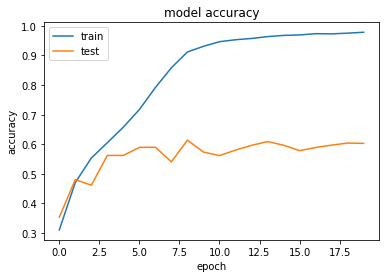

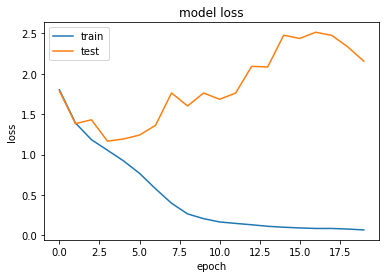

In [29]:
## Gathering model stats
model_stats(emotion)

### Tuning the Model

In [30]:
## Adding dropout layer to stop overfitting

def emotion_model(input_shape,fun_activation='relu',dropout_value = 0.2,fun_loss = 'categorical_crossentrophy'):
  model = Sequential()
  model.add(Conv2D(filters=64,kernel_size=(5,5),input_shape = input_shape,activation = fun_activation, padding='same'))
  model.add(Conv2D(filters=64, kernel_size=(5,5),activation=fun_activation, padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(dropout_value))

  model.add(Conv2D(filters=128,kernel_size=(5,5),input_shape = input_shape,activation = fun_activation, padding='same'))
  model.add(Conv2D(filters=128, kernel_size=(5,5),activation=fun_activation, padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(dropout_value))

  model.add(Conv2D(filters=256,kernel_size=(5,5),input_shape = input_shape,activation = fun_activation, padding='same'))
  model.add(Conv2D(filters=256, kernel_size=(5,5),activation=fun_activation, padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(dropout_value))

  model.add(Flatten())
  model.add(Dense(128, activation=fun_activation))
  model.add(BatchNormalization())
  model.add(Dropout(dropout_value))
  model.add(Dense(7,activation='softmax'))

  model.compile(loss=fun_loss,metrics=['accuracy'])

  return model

model_2 = emotion_model(input_shape,'relu',0.3,'categorical_crossentropy')
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_4 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 128)      

In [31]:
## Adding Early Stopping

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, ## increasing the patience
                                            verbose=2, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [32]:
emotion_2 = model_2.fit( x = X_train, y = Y_train, 
                    batch_size = 120, 
                    epochs = 50, 
                    verbose = 2,
                    validation_data=(X_val, Y_val),
                    callbacks= callbacks
                    )

Epoch 1/50
240/240 - 25s - loss: 1.9384 - accuracy: 0.2855 - val_loss: 2.0116 - val_accuracy: 0.1744
Epoch 2/50
240/240 - 19s - loss: 1.5456 - accuracy: 0.4227 - val_loss: 1.6326 - val_accuracy: 0.3592
Epoch 3/50
240/240 - 19s - loss: 1.3228 - accuracy: 0.5009 - val_loss: 1.4225 - val_accuracy: 0.4687
Epoch 4/50
240/240 - 19s - loss: 1.1806 - accuracy: 0.5543 - val_loss: 1.2639 - val_accuracy: 0.5222
Epoch 5/50
240/240 - 19s - loss: 1.0685 - accuracy: 0.5998 - val_loss: 1.1882 - val_accuracy: 0.5414
Epoch 6/50
240/240 - 19s - loss: 0.9726 - accuracy: 0.6383 - val_loss: 1.1488 - val_accuracy: 0.5801
Epoch 7/50
240/240 - 19s - loss: 0.8745 - accuracy: 0.6814 - val_loss: 1.2591 - val_accuracy: 0.5564
Epoch 8/50
240/240 - 19s - loss: 0.7772 - accuracy: 0.7164 - val_loss: 1.1452 - val_accuracy: 0.5977
Epoch 9/50
240/240 - 19s - loss: 0.6724 - accuracy: 0.7567 - val_loss: 1.2460 - val_accuracy: 0.5879
Epoch 10/50
240/240 - 19s - loss: 0.5688 - accuracy: 0.7947 - val_loss: 1.2757 - val_accura

In [33]:
model_2.evaluate(X_test,Y_test, verbose=2)

113/113 - 1s - loss: 1.7699 - accuracy: 0.6328


[1.7699040174484253, 0.6327667832374573]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


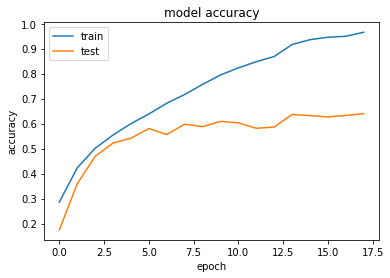

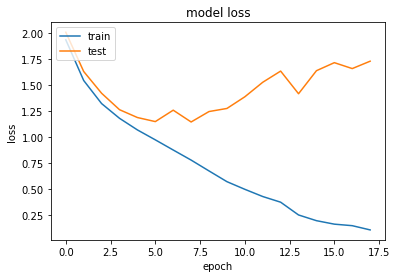

In [34]:
## Gathering model stats
model_stats(emotion_2)

In [35]:
model_3 = emotion_model(input_shape,'relu',0.4,'categorical_crossentropy')
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_8 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 128)       204928    
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 24, 24, 128)      

In [36]:
emotion_3 = model_3.fit( x = X_train, y = Y_train, 
                    batch_size = 64, 
                    epochs = 50, 
                    verbose = 2,
                    validation_data=(X_test,Y_test),
                    callbacks= callbacks
                    )

Epoch 1/50
449/449 - 21s - loss: 2.0102 - accuracy: 0.2705 - val_loss: 1.6800 - val_accuracy: 0.3168
Epoch 2/50
449/449 - 19s - loss: 1.6288 - accuracy: 0.3872 - val_loss: 5.2137 - val_accuracy: 0.1415
Epoch 3/50
449/449 - 19s - loss: 1.4357 - accuracy: 0.4487 - val_loss: 1.4649 - val_accuracy: 0.4433
Epoch 4/50
449/449 - 19s - loss: 1.2995 - accuracy: 0.5047 - val_loss: 1.3718 - val_accuracy: 0.4675
Epoch 5/50
449/449 - 19s - loss: 1.2045 - accuracy: 0.5432 - val_loss: 1.3693 - val_accuracy: 0.5155
Epoch 6/50
449/449 - 19s - loss: 1.1370 - accuracy: 0.5721 - val_loss: 1.3628 - val_accuracy: 0.4765
Epoch 7/50
449/449 - 19s - loss: 1.0678 - accuracy: 0.6016 - val_loss: 1.3061 - val_accuracy: 0.5171
Epoch 8/50
449/449 - 19s - loss: 1.0080 - accuracy: 0.6241 - val_loss: 1.1681 - val_accuracy: 0.5782
Epoch 9/50
449/449 - 19s - loss: 0.9479 - accuracy: 0.6476 - val_loss: 1.1780 - val_accuracy: 0.5801
Epoch 10/50
449/449 - 19s - loss: 0.8897 - accuracy: 0.6696 - val_loss: 1.1271 - val_accura

In [37]:
model_3.evaluate(X_test,Y_test, verbose=2)

113/113 - 1s - loss: 1.4643 - accuracy: 0.6250


[1.464269995689392, 0.6249651908874512]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


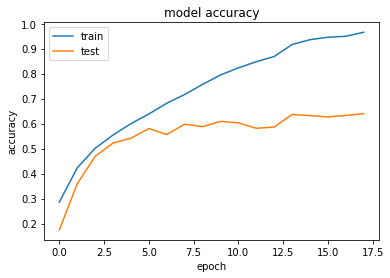

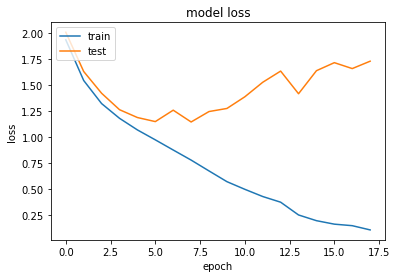

In [38]:
## Gathering model stats
model_stats(emotion_2)

In [39]:
## Saving the model with best accuracy

model_3.save("emotion_detection_model.h5")


## Loading the model and verifying the output of prediction

In [40]:
## Loading the saved model using Keras
new_model = load_model("emotion_detection_model.h5")
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_8 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 128)       204928    
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 24, 24, 128)      

In [41]:
## Saving model to JSON

fer_json = new_model.to_json()
with open("fer.json", "w") as json_file:
    json_file.write(fer_json)

In [42]:
## Function to check prediction of Model
def check_prediction(model,row_id,data_check,data_verify=None):
  ## Predicting the output using model
  predict = model.predict(data_check['pixels'][row_id].reshape(1,48,48,1))[0]
  #print(predict)
  a = 0
  pos = 0
  ## Getting the position of maximum probability of prediction
  for i in range(len(predict)):
    if predict[i] > a :
      a = predict[i]
      pos = i
  emotion = {0 : "Angry", 1 : "Disgust", 2 : "Fear", 3 : "Happy", 4 : "Sad", 5 : "Surprise", 6 : "Neutral"}
  print('Prediction Image--> '+ emotion[pos])

  print("\n\nActual Image -->")
  ## Calling reusable function
  view_image(data_verify,row_id)



Prediction Image--> Happy


Actual Image -->
3 Happy


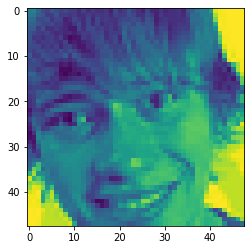

In [43]:
check_prediction(new_model,7997,df_face,df)

Prediction Image--> Angry


Actual Image -->
0 Angry


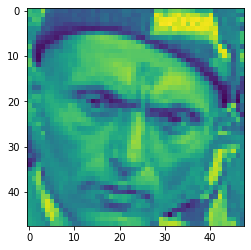

In [44]:
check_prediction(new_model,765,df_face,df)

Prediction Image--> Fear


Actual Image -->
2 Fear


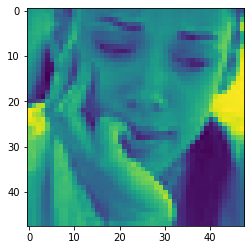

In [45]:
check_prediction(new_model,1389,df_face,df)

Prediction Image--> Happy


Actual Image -->
3 Happy


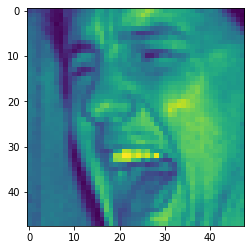

In [46]:
check_prediction(new_model,7685,df_face,df)

## OpenCV - Using Haar Cascade file to check emotion in real time

In [47]:
## Importing Libraries

import os
import cv2
import numpy as np
from keras.models import model_from_json
from keras.preprocessing import image

In [50]:
#load model
model_realtime = model_from_json(open("fer.json", "r").read())
#load weights
model_realtime.load_weights('emotion_detection_model.h5')

#loading Haar Cascade weights
face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [ ]:
cap=cv2.VideoCapture(0)

while True:
    ret,test_img=cap.read()# captures frame and returns boolean value and captured image
    
    if not ret:
        continue
    gray_img= cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

    faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.32, 5)


    for (x,y,w,h) in faces_detected:
        cv2.rectangle(test_img,(x,y),(x+w,y+h),(255,0,0),thickness=7)
        roi_gray=gray_img[y:y+w,x:x+h]#cropping region of interest i.e. face area from  image
        roi_gray=cv2.resize(roi_gray,(48,48))
        img_pixels = image.img_to_array(roi_gray)
        img_pixels = np.expand_dims(img_pixels, axis = 0)
        img_pixels /= 255

        predictions = model_realtime.predict(img_pixels)

        #find max indexed array
        max_index = np.argmax(predictions[0])

        emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
        predicted_emotion = emotions[max_index]

        cv2.putText(test_img, predicted_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

    resized_img = cv2.resize(test_img, (1000, 700))
    cv2.imshow('Facial emotion analysis ',resized_img)



    if cv2.waitKey(10) == ord('q'):#wait until 'q' key is pressed
        break

cap.release()
cv2.destroyAllWindows

## Summary

- Fer Dataset is inported into dataframe
- Data is splitted in different pixels values
- Pixels are converted into float32 and then normalised
- Data is then divided into train, test and validation based on usgae column
- Similarly the target variable is also converted to categorical value
- A basic model is created, complied and model is trainned
- Then the model is tuned by adding dropout layer and the model is complied and trainned
- In next stage callback is used for early stopping
- The final model is then saved as h5 and json format
- Prediction is performed on the model
- Finally the model is used for real time emotion prediction using Haar Casacade of face detection 
